<a href="https://www.kaggle.com/code/tonysiu/google-i-o-demo?scriptVersionId=132087624" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


### 1. Install Pytorch

In [1]:
!pip3 install torch torchvision   # install pytorch

### 2. Check GPU

In [2]:
!/opt/bin/nvidia-smi  #show GPU 

Sat Jun  3 08:32:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

### 3. Get model from Google Drive
* **[How to wget from google drive](https://chemicloud.com/blog/download-google-drive-files-using-wget/)**

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SjBabB7_wpOyX-B4Vuc5hi4zIDjlYiif' -O model.pth

--2023-06-03 08:32:18--  https://docs.google.com/uc?export=download&id=1SjBabB7_wpOyX-B4Vuc5hi4zIDjlYiif
Resolving docs.google.com (docs.google.com)... 142.250.136.139, 142.250.136.113, 142.250.136.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.136.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l12luqhpeeo5c1d6ovuen82qt6ii7rkr/1685781075000/11618589740366079480/*/1SjBabB7_wpOyX-B4Vuc5hi4zIDjlYiif?e=download&uuid=19ff8f86-1ba9-4aa4-9c31-dae444948013 [following]
--2023-06-03 08:32:18--  https://doc-10-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l12luqhpeeo5c1d6ovuen82qt6ii7rkr/1685781075000/11618589740366079480/*/1SjBabB7_wpOyX-B4Vuc5hi4zIDjlYiif?e=download&uuid=19ff8f86-1ba9-4aa4-9c31-dae444948013
Resolving doc-10-74-docs.googleusercontent.com (doc-10-74-docs.googleusercontent.com)... 172.217.219.132, 2607:

### 4. Code

In [4]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
args = {}
args['batch_size'] = 2048
args['test_batch_size'] = 2048 
args['epochs'] = 5  #The number of Epochs is the number of times you go through the full dataset. 
args['lr'] = 0.01 #Learning rate is how fast it will decend. 
args['log_interval'] = 10

In [6]:
import random
import numpy as np
from typing import Tuple

def save_checkpoint(
    save_path:str,
    model:torch.nn.Module, 
    optimizer:torch.optim, 
)->None:

    if save_path == None:
        return

    state_dict = {
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(state_dict, save_path)
    print(f'Checkpoint saved to ==> {save_path}')


def load_checkpoint(
    load_path:str, 
    model:torch.nn.Module, 
    optimizer:torch.optim,
    device:torch.device
)->Tuple:
    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Checkpoint loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return model,optimizer,state_dict


def save_metrics(
    save_path:str, 
    loss_callback:tuple, 
    f1_callback:tuple, 
    ap_callback:tuple,
    emr_callback:tuple,
    val_loss_callback:tuple, 
    val_f1_callback:tuple,
    val_ap_callback:tuple,
    val_emr_callback:tuple,
)->None:

    if save_path == None:
        return

    state_dict = {'loss_callback': (loss_callback,val_loss_callback),
                  'f1_callback': (f1_callback,val_f1_callback),
                  'ap_callback':(ap_callback,val_ap_callback),
                  'emr_callback':(emr_callback,val_emr_callback),}

            
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(
    load_path:str,
    device:torch.device
)->Tuple:
    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict


def torch_seeding(seed=12345):
    """
    CUBLAS_WORKSPACE_CONFIG=:4096:8 python3 torch_training.py --train
    """
    # Application-side randomness
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Benchmarking randomness
    torch.backends.cudnn.benchmark = False

    # CUDA algorithmic randomness
    torch.use_deterministic_algorithms(True,warn_only=True)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

torch_seeding(seed=12345)

In [7]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])
# Store metrics
losses,val_losses,accs = (),(),()

In [9]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 95888260.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62764608.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27499011.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11981464.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 28, 28])


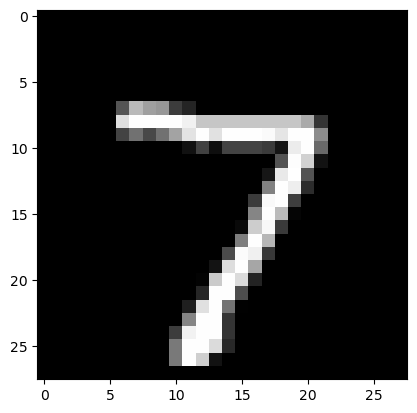

In [10]:
import matplotlib.pyplot as plt

for data,target in test_loader:
    print(data[0].shape)
    plt.imshow(data[0].permute(1,2,0), cmap='gray')
    plt.show()
    break

In [11]:
def train(
    epoch:int,
    model:torch.nn.Module,
    criterion:torch.nn,
    optimizer:torch.optim,
    save_path:str='/content/gdrive/MyDrive/Explore_ML_Crowdsource',
    load_from_check_point:bool=False
)->float:
    if load_from_check_point:
        model,optimizer,_ = load_checkpoint(
            load_path=f'{save_path}/model.pth',
            model=model,
            optimizer=optimizer,
            device='cuda:0'
        )
    losses = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()
        
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses += loss.item()

    save_checkpoint(
        save_path=f'{save_path}/model.pth', 
        model=model,
        optimizer=optimizer, 
    )
    return ((losses / (batch_idx + 1)) \
            if batch_idx else losses,)

In [12]:
def test(
    model:torch.nn.Module,
    criterion:torch.nn,
)->tuple:
    model.eval()
    test_loss = correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()

            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] 
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset),test_loss


In [13]:
for epoch in range(1, args['epochs'] + 1):
    loss = train(epoch,model,criterion,optimizer,save_path='/kaggle/working')
    acc,val_loss = test(model,criterion)
    losses += loss
    val_losses += (val_loss,)
    accs += (acc,)


/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295331
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.269856
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.243961
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0011, Accuracy: 2558/10000 (26%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.217538
Train Epoch: 2 [20480/60000 (33%)]	Loss: 2.187626
Train Epoch: 2 [40960/60000 (67%)]	Loss: 2.144623
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0011, Accuracy: 4893/10000 (49%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.107056
Train Epoch: 3 [20480/60000 (33%)]	Loss: 2.057911
Train Epoch: 3 [40960/60000 (67%)]	Loss: 2.007619
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0010, Accuracy: 6092/10000 (61%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.941487
Train Epoch: 4 [20480/60000 (33%)]	Loss: 1.883633
Train Epoch: 4 [40960/60000 (67%)]	Loss: 1.806546
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0009, Accu

In [14]:
for epoch in range(1, args['epochs'] + 1):
    loss = train(
        epoch=epoch,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        save_path='/kaggle/working',
        load_from_check_point=True
    )
    acc,val_loss = test(model,criterion)
    losses += loss
    val_losses += (val_loss,)
    accs += (acc,)

Checkpoint loaded from <== /kaggle/working/model.pth
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.475484
Train Epoch: 1 [20480/60000 (33%)]	Loss: 1.394892
Train Epoch: 1 [40960/60000 (67%)]	Loss: 1.302154
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0006, Accuracy: 7712/10000 (77%)

Checkpoint loaded from <== /kaggle/working/model.pth
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.219667
Train Epoch: 2 [20480/60000 (33%)]	Loss: 1.157191
Train Epoch: 2 [40960/60000 (67%)]	Loss: 1.085014
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0005, Accuracy: 7996/10000 (80%)

Checkpoint loaded from <== /kaggle/working/model.pth
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.004833
Train Epoch: 3 [20480/60000 (33%)]	Loss: 0.968583
Train Epoch: 3 [40960/60000 (67%)]	Loss: 0.931995
Checkpoint saved to ==> /kaggle/working/model.pth

Test set: Average loss: 0.0004, Accuracy: 8227/10000 (82%)

Checkpoint loaded from <== /kaggle/working/model.pth
Train Epoch: 4 [0/60

In [15]:
import matplotlib.pyplot as plt
from typing import Iterable

def plot_callback(
    train_metric: Iterable,
    val_metric: Iterable,
    name: str, num=0
) -> None:
    plt.figure(num=num, figsize=(16, 4), dpi=200)
    plt.plot(val_metric)
    plt.plot(train_metric)
    plt.legend(["val_{}".format(name), "{}".format(name), ])
    plt.xlabel("# Epochs")
    plt.ylabel("{}".format(name))
    plt.title("{} MLP".format(name))
    plt.show()

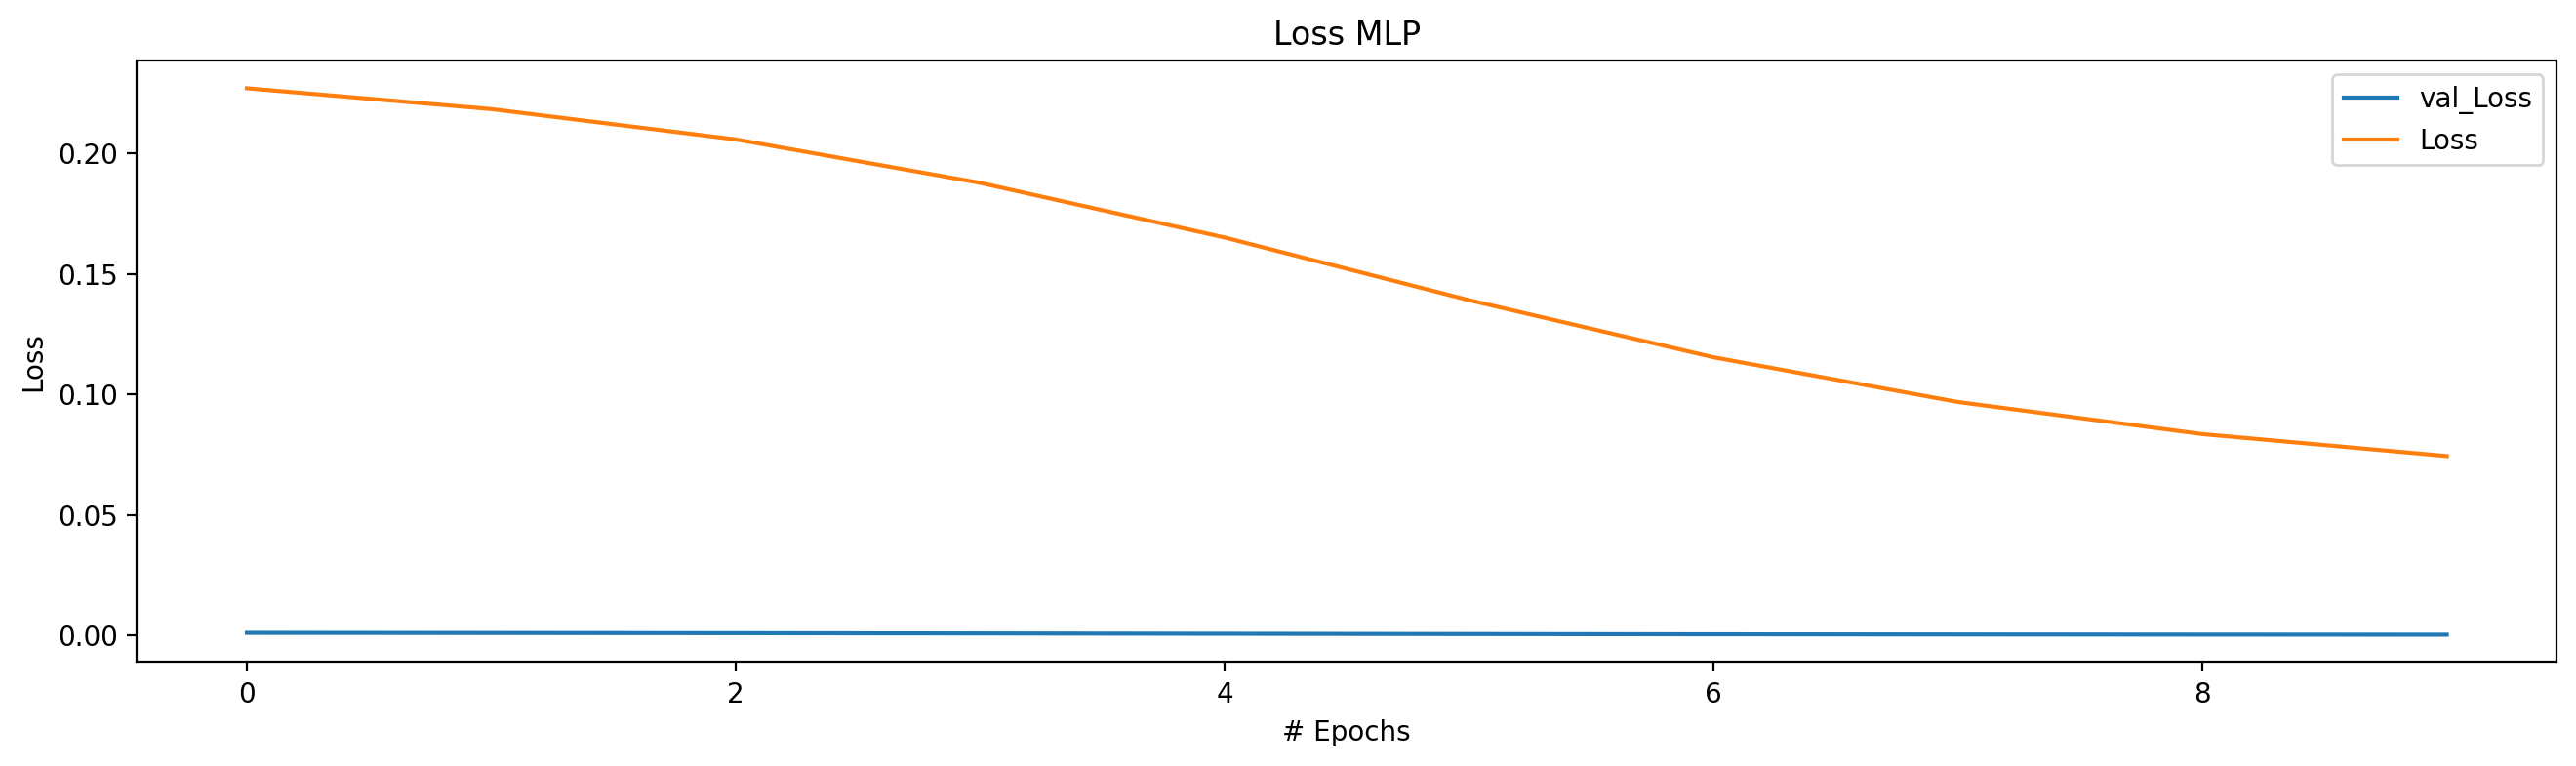

In [16]:
plot_callback(losses,val_losses,name='Loss')

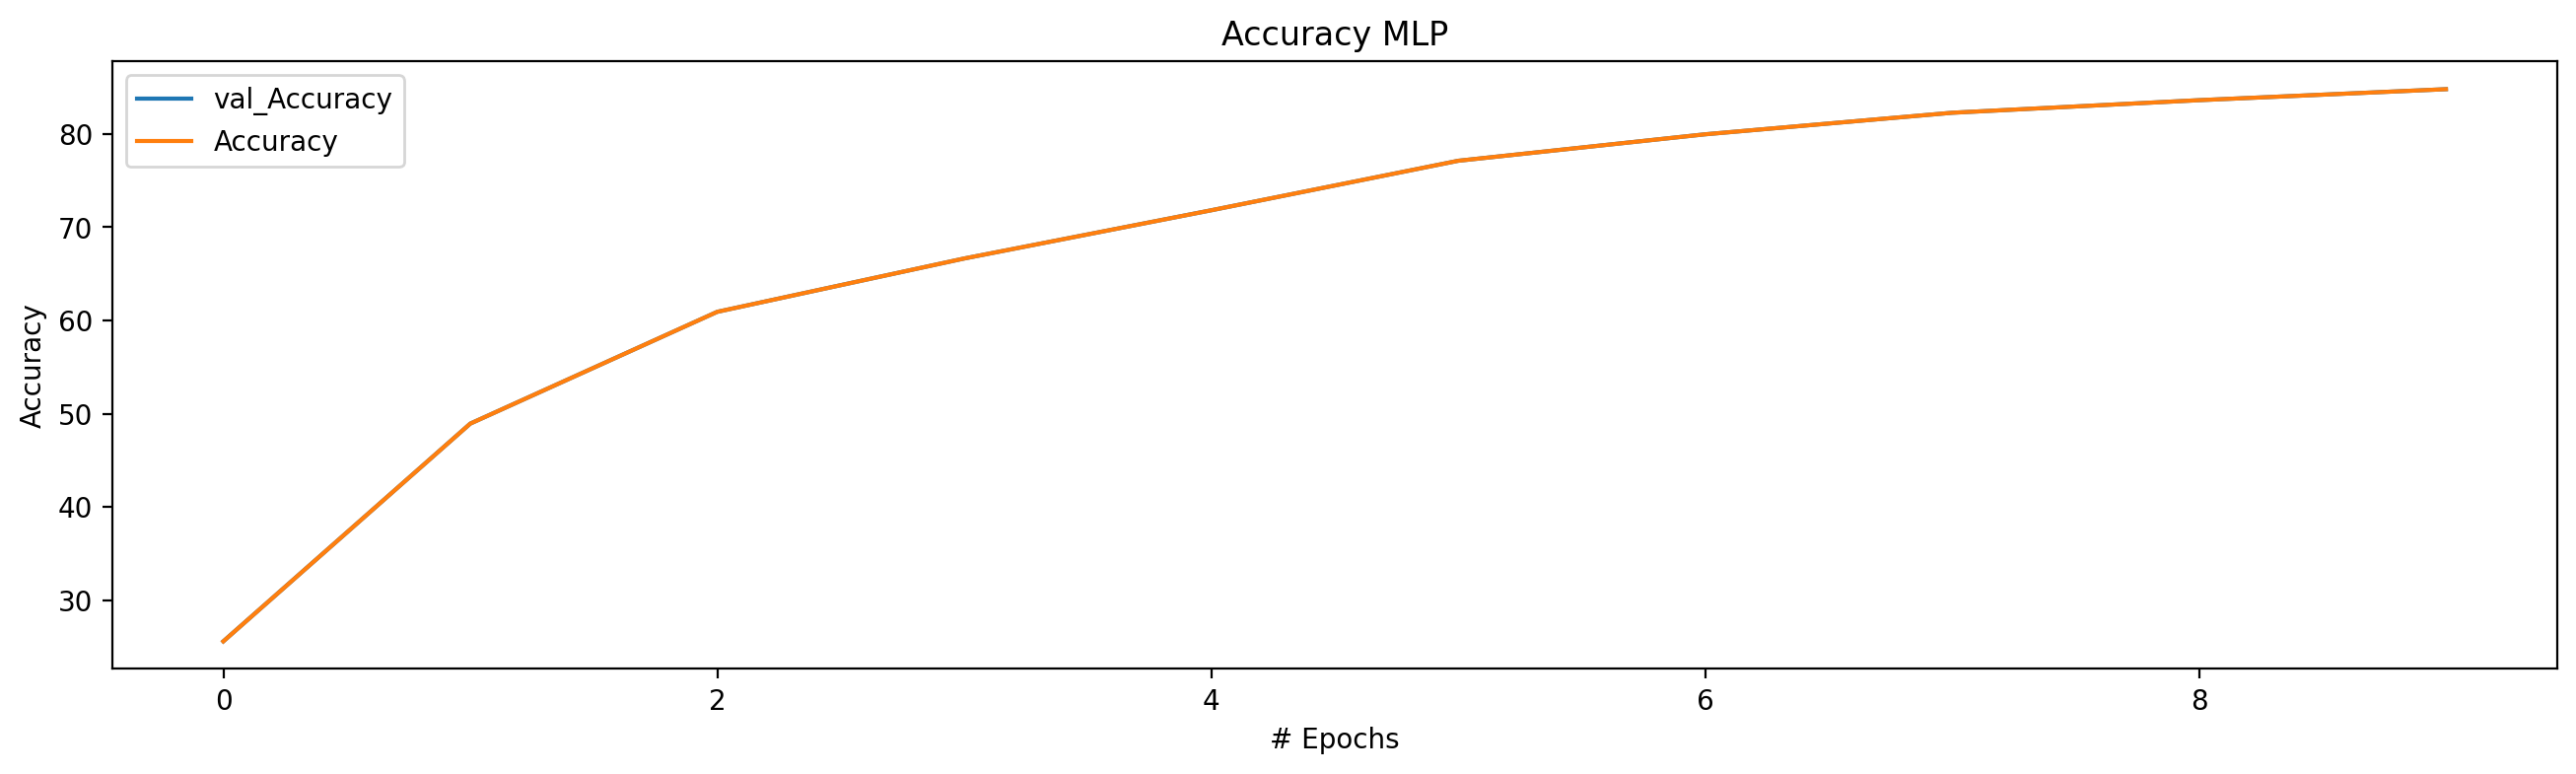

In [17]:
plot_callback(accs,accs,name='Accuracy')

In [18]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

--2023-06-03 08:34:50--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: ‘ViT-B_16.npz’

ViT-B_16.npz        100%[===================>] 393.69M  36.2MB/s    in 12s     

2023-06-03 08:35:02 (33.9 MB/s) - ‘ViT-B_16.npz’ saved [412815506/412815506]

